In [360]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


import scipy.interpolate as interp
import lalsimulation as lal
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
from keras import metrics
import keras_metrics as km
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt
import pathlib 
import shutil
import tempfile
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
#gpu configuration:

gpu_num = 1

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

2 Physical GPUs, 2 Logical GPUs
Visible devices cannot be modified after being initialized


In [347]:
df = pd.read_csv('preprocessing.csv', index_col = 0)
df

m1        m2        l1        l2    gamma0  logp1_cgs    gamma1  \
0      1.704363  0.940013  1.686090  3.498810  2.749811  35.365482  4.163723   
1      0.674195  0.488352  4.630310  5.249203  3.595422  34.654207  3.981949   
2      1.944506  1.625537  2.224806  2.701013  3.520350  35.396764  4.952541   
3      0.582582  0.362044  4.685642  5.651456  2.917128  35.255684  1.149857   
4      2.684166  2.462512  1.709042  1.964290  4.252634  34.932686  3.321473   
...         ...       ...       ...       ...       ...        ...       ...   
49995  1.093111  0.866491  1.965994  2.528221  3.791754  33.440527  4.773079   
49996  0.450100  0.421913  3.340404  4.616534  2.362006  33.940821  2.777913   
49997  1.229125  0.916376  2.503452  3.099723  3.293796  33.026767  4.130634   
49998  0.884386  0.667397  2.974374  5.247997  4.598794  35.306336  3.806648   
49999  2.689961  0.624463  3.588572  4.208695  4.750452  34.792232  4.234088   

       logp2_cgs    gamma2  
0      35.765971  1.138051  
1      34.993765  1.593887  
2      36.017062  1.272790  
3      36.029744  1.967677  
4      35.708051  1.456522  
...          ...       ...  
49995  36.900283  1.091320  
49996  34.595926  1.535013  
49997  34.994576  2.092221  
49998  35.632485  1.049226  
49999  35.206430  1.144645  

[50000 rows x 9 columns]

In [348]:
normeddata = df.copy(deep = True )

In [349]:
def normalizeandwhiten(x):
    gamma0_norm = (x['gamma0'] - 1) / (5 - 1)
    gamma1_norm = (x['gamma1'] - 1) / (5 - 1)
    gamma2_norm = (x['gamma2'] - 1) / (5 - 1)
    #normalizating p values
    logp1_cgs_norm = (x['logp1_cgs'] - 33) / (37 - 33)
    logp2_cgs_norm = (x['logp2_cgs'] - 33) / (37 - 33)
    return gamma0_norm, logp1_cgs_norm, gamma1_norm, logp2_cgs_norm, gamma2_norm
#print(gamma0_norm)
# Call the function and save the normalized values to 'normeddata'
normeddata['gamma0'], normeddata['logp1_cgs'], normeddata['gamma1'], normeddata['logp2_cgs'], normeddata['gamma2'] = normalizeandwhiten(normeddata)

In [350]:
m1norm = (df['m1'] - df['m1'].min())/ (df['m1'].max()-df['m1'].min())
m2norm = (df['m2'] - df['m2'].min())/ (df['m2'].max()-df['m2'].min())
l1norm = (df['l1'] - df['l1'].min())/ (df['l1'].max()-df['l1'].min())
l2norm = (df['l2'] - df['l2'].min())/ (df['l2'].max()-df['l2'].min())
normeddata['m1'] = m1norm
normeddata['m2'] = m2norm
normeddata['l1'] = l1norm
normeddata['l2'] = l2norm 
normeddata

m1        m2        l1        l2    gamma0  logp1_cgs    gamma1  \
0      0.365400  0.173741  0.279635  0.543609  0.437453   0.591370  0.790931   
1      0.098087  0.054358  0.765004  0.846278  0.648856   0.413552  0.745487   
2      0.427714  0.354939  0.368445  0.405658  0.630087   0.599191  0.988135   
3      0.074315  0.020973  0.774126  0.915834  0.479282   0.563921  0.037464   
4      0.619644  0.576167  0.283419  0.278268  0.813159   0.483171  0.580368   
...         ...       ...       ...       ...       ...        ...       ...   
49995  0.206790  0.154308  0.325778  0.375780  0.697939   0.110132  0.943270   
49996  0.039938  0.036797  0.552357  0.736880  0.340501   0.235205  0.444478   
49997  0.242083  0.167493  0.414381  0.474601  0.573449   0.006692  0.782659   
49998  0.152629  0.101683  0.492015  0.846070  0.899699   0.576584  0.701662   
49999  0.621148  0.090335  0.593269  0.666359  0.937613   0.448058  0.808522   

       logp2_cgs    gamma2  
0       0.691493  0.034513  
1       0.498441  0.148472  
2       0.754266  0.068198  
3       0.757436  0.241919  
4       0.677013  0.114131  
...          ...       ...  
49995   0.975071  0.022830  
49996   0.398982  0.133753  
49997   0.498644  0.273055  
49998   0.658121  0.012307  
49999   0.551607  0.036161  

[50000 rows x 9 columns]

In [351]:
train_dataset = normeddata.sample(frac=0.8, random_state=1)
test_dataset = normeddata.drop(train_dataset.index)

In [352]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [353]:
train_copy = train_dataset.copy()
test_copy = test_dataset.copy()

In [354]:
train_label = train_copy.drop(columns = ['m1', 'm2', 'l1', 'l2']) #pandas with gamma0, gamma1, logp1, logp2, gamma2 large training
test_label = test_copy.drop(columns = ['m1', 'm2', 'l1', 'l2']) #pandas with gamma0, gamma1, logp1, logp2, gamma2 small testing

train_features = train_copy.drop(columns = ['gamma0', 'gamma1', 'gamma2', 'logp1_cgs', 'logp2_cgs']) #m1, m2, l1,l2 large
test_features = test_copy.drop(columns = ['gamma0', 'gamma1', 'gamma2', 'logp1_cgs', 'logp2_cgs']) #m1,m2,l1,l2 small


In [355]:
train_label.shape

(40000, 5)

In [356]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import BatchNormalization
from keras import regularizers

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import HyperParameters, BayesianOptimization
from keras.regularizers import l2
import keras_tuner
import keras


In [357]:
#custom objective function
#def rmse(y_true, y_pred):
    #return np.sqrt(((y_true - y_targ) ** 2).mean())

train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1],1))
print(train_features)

In [358]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                 patience=200,
                                 min_delta=0.001, 
                                 mode='auto') 

model = Sequential()
model.add(Conv1D(filters = 16, kernel_size = 1, activation = 'relu', input_shape = (4,1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size =2))
model.add(Flatten())
model.add(Dense(514, activation = 'relu'))#, kernel_regularizer = keras.regularizers.L2(0.0001)))
model.add(Dense(1))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001, clipnorm =1, use_ema =True, amsgrad = True),
              loss = 'cosine_similarity')

history = model.fit(train_features, train_label, epochs = 200, verbose =1, callbacks = callback)

In [359]:
len(train_features.T)


4

def conv_pool_cnn(model_input: Tensor) -> training.Model:
    
    x = Conv1D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(10, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='conv_pool_cnn')
    
    return model


conv_pool_cnn_model = conv_pool_cnn(model_input)


In [361]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import os

In [364]:

base_model = keras.Sequential([
keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape = (4,1)),
#keras.layers.BatchNormalization(),
#keras.layers.Dense(units=32, activation='relu'),
keras.layers.MaxPooling1D(pool_size=2),
keras.layers.Flatten(),
keras.layers.Dense(units=64, activation='relu'),
keras.layers.Dense(5)
])
base_model.compile(loss = 'cosine_similarity', optimizer = 'sgd')
base_model.fit(train_features, train_label, epochs =30, verbose =0)


/home/smith26/anaconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [345]:
os.makedirs('models')

In [ ]:
n_models = 5
for i in range(n_models):
    

In [325]:
import numpy as np
import tensorflow as tf
from tensorflow import keras



base_model = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=32, activation='relu'),
    #keras.layers.MaxPooling1D(pool_size=2)
])
base_model.compile(loss = 'cosine_similarity', optimizer = 'adam')

model_gamma0 = keras.Sequential([
    keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=1),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model_logp1 = keras.Sequential([
    keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=1),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model_gamma1 = keras.Sequential([
    keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=1),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model_logp2 = keras.Sequential([
    keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=1),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model_gamma2 = keras.Sequential([
    keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=1),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

input_shape = (train_features.shape[1], 1)
input_layer = keras.layers.Input(shape=input_shape)
z = base_model(input_layer)

gamma0 = model_gamma0(z)
logp1 = model_logp1(z)
gamma1 = model_gamma1(z)
logp2 = model_logp2(z)
gamma2 = model_gamma2(z)


model = keras.Model(inputs=input_layer, outputs=[gamma0, logp1, gamma1, logp2, gamma2])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1),
              loss= tf.keras.losses.CosineSimilarity(axis=-1, name='gamma0_cosine_similarity'))

history = model.fit(train_features, train_label,
                    epochs=200, verbose=1, callbacks=callback)


Epoch 1/200


/home/smith26/anaconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.0000
Epoch 2/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0000
Epoch 3/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 4/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 5/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 6/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0000
Epoch 7/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 8/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 9/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 10/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0000
Epoch 11/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 12/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 13/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 14/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0000
Epoch 15/200
1250/1250 ━━━━

In [326]:
test_predictions = model.predict(train_features)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [327]:
model.summary


<bound method Model.summary of <Functional name=functional_440, built=True>>

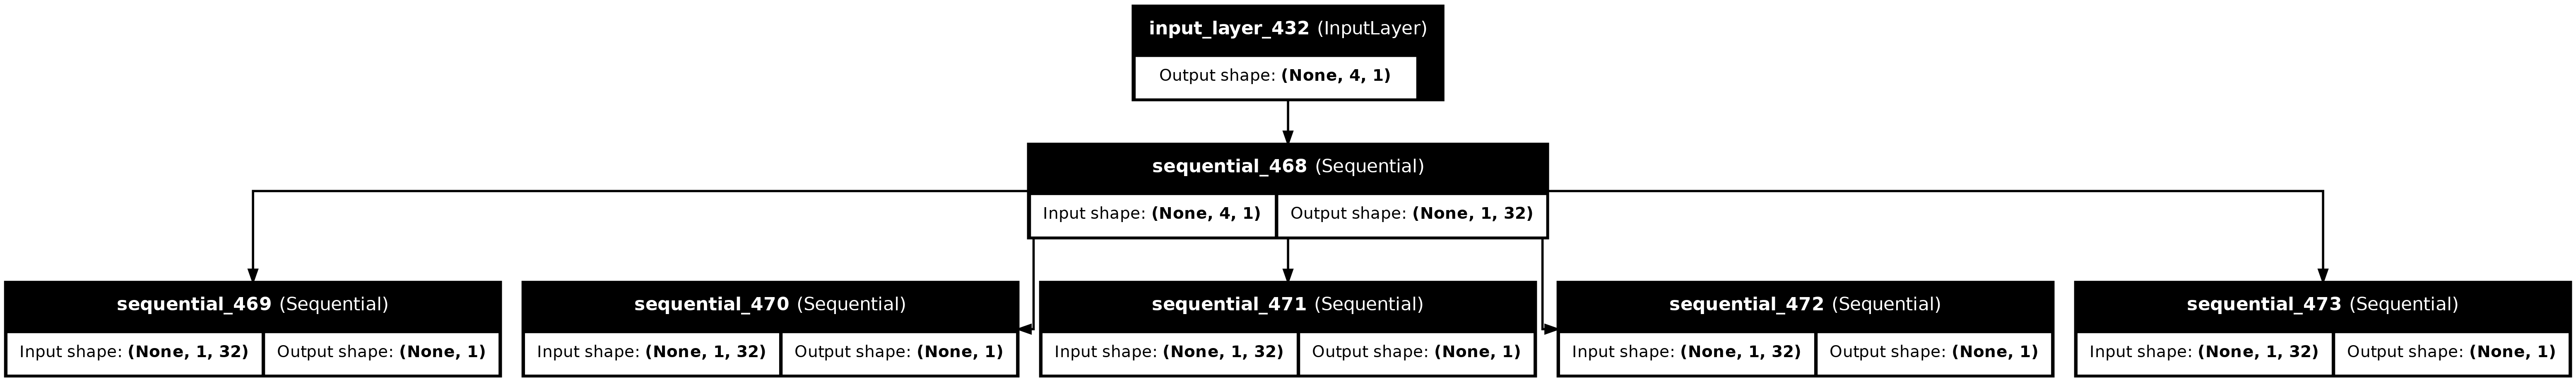

In [328]:
plot_model(model, show_shapes = True, show_layer_names = True)

In [329]:
print(test_predictions)

[array([[-0.606],
       [-0.343],
       [-0.162],
       ...,
       [-0.83 ],
       [-0.963],
       [-0.584]], dtype=float32), array([[ 0.365],
       [-0.712],
       [-0.322],
       ...,
       [ 0.747],
       [ 0.559],
       [ 0.128]], dtype=float32), array([[-1.089],
       [-0.33 ],
       [-0.28 ],
       ...,
       [-1.17 ],
       [ 0.072],
       [-0.486]], dtype=float32), array([[ 0.528],
       [ 0.239],
       [ 0.278],
       ...,
       [ 0.528],
       [-0.24 ],
       [ 0.31 ]], dtype=float32), array([[-0.781],
       [-0.17 ],
       [ 0.044],
       ...,
       [-0.732],
       [-0.841],
       [-0.645]], dtype=float32)]


In [330]:
lab_max = normeddata['gamma0'].max()
lab_min = normeddata['gamma0'].min()
lab_range = lab_max - lab_min
lab_mean = normeddata['gamma0'].mean()
print(lab_max, lab_min, lab_range, lab_mean)

0.99999834196278 7.982410285611863e-05 0.9999185178599239 0.6411786126206468


In [331]:
pred_max = test_predictions[:][0].max()
pred_min = test_predictions[:][0].min()
pred_range = pred_max - pred_min
pred_mean = test_predictions[:][0].mean()
print(pred_max, pred_min, pred_range, pred_mean)

0.00067747384 -4.010535 4.0112123 -0.50828636


In [332]:
predictions_array_length = 40000
numcols = 10
array_sizes =  np.array([[0] * numcols ] * predictions_array_length,dtype='float64')
predictions = pd.DataFrame(array_sizes)
predictions.columns = [ 'gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted', 'gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted','logp2_cgs_predicted', 'gamma2_predicted']

In [333]:
predictions['gamma0_norm_predicted'] = test_predictions[:][0]
predictions['logp1_cgs_norm_predicted'] = test_predictions[:][1]
predictions['gamma1_norm_predicted'] = test_predictions[:][2]
predictions['logp2_cgs_norm_predicted'] = test_predictions[:][3]
predictions['gamma2_norm_predicted'] = test_predictions[:][4]
predictions

gamma0_norm_predicted  logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                  -0.605898                  0.364640              -1.089054   
1                  -0.343095                 -0.711635              -0.330494   
2                  -0.161713                 -0.322362              -0.280296   
3                  -0.463729                  0.124134              -0.170771   
4                  -0.137681                  0.394157              -0.449472   
...                      ...                       ...                    ...   
39995              -0.612810                  0.429568              -0.375263   
39996              -0.384680                 -0.197803              -0.334606   
39997              -0.829579                  0.746673              -1.169566   
39998              -0.962561                  0.559256               0.071588   
39999              -0.584190                  0.128408              -0.485747   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                      0.527594              -0.781491               0.0   
1                      0.239425              -0.170106               0.0   
2                      0.277697               0.043547               0.0   
3                      0.166685              -0.228451               0.0   
4                      0.360440              -0.146087               0.0   
...                         ...                    ...               ...   
39995                  0.306772              -0.484501               0.0   
39996                  0.265425              -0.065801               0.0   
39997                  0.528225              -0.732136               0.0   
39998                 -0.240048              -0.840522               0.0   
39999                  0.310473              -0.645456               0.0   

       logp1_cgs_predicted  gamma1_predicted  logp2_cgs_predicted  \
0                      0.0               0.0                  0.0   
1                      0.0               0.0                  0.0   
2                      0.0               0.0                  0.0   
3                      0.0               0.0                  0.0   
4                      0.0               0.0                  0.0   
...                    ...               ...                  ...   
39995                  0.0               0.0                  0.0   
39996                  0.0               0.0                  0.0   
39997                  0.0               0.0                  0.0   
39998                  0.0               0.0                  0.0   
39999                  0.0               0.0                  0.0   

       gamma2_predicted  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
39995               0.0  
39996               0.0  
39997               0.0  
39998               0.0  
39999               0.0  

[40000 rows x 10 columns]

In [334]:
predictions['gamma0_predicted'] = test_predictions[:][0]* (5 - 1) + 1 
predictions['logp1_cgs_predicted'] = test_predictions[:][1] *  (37 - 33) + 33
predictions['gamma1_predicted'] = test_predictions[:][2]* (5 - 1) + 1
predictions['logp2_cgs_predicted'] = test_predictions[:][3] *  (37 - 33) + 33
predictions['gamma2_predicted'] = test_predictions[:][4]* (5 - 1) + 1
predictions

gamma0_norm_predicted  logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                  -0.605898                  0.364640              -1.089054   
1                  -0.343095                 -0.711635              -0.330494   
2                  -0.161713                 -0.322362              -0.280296   
3                  -0.463729                  0.124134              -0.170771   
4                  -0.137681                  0.394157              -0.449472   
...                      ...                       ...                    ...   
39995              -0.612810                  0.429568              -0.375263   
39996              -0.384680                 -0.197803              -0.334606   
39997              -0.829579                  0.746673              -1.169566   
39998              -0.962561                  0.559256               0.071588   
39999              -0.584190                  0.128408              -0.485747   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                      0.527594              -0.781491         -1.423593   
1                      0.239425              -0.170106         -0.372380   
2                      0.277697               0.043547          0.353149   
3                      0.166685              -0.228451         -0.854917   
4                      0.360440              -0.146087          0.449278   
...                         ...                    ...               ...   
39995                  0.306772              -0.484501         -1.451241   
39996                  0.265425              -0.065801         -0.538722   
39997                  0.528225              -0.732136         -2.318315   
39998                 -0.240048              -0.840522         -2.850244   
39999                  0.310473              -0.645456         -1.336759   

       logp1_cgs_predicted  gamma1_predicted  logp2_cgs_predicted  \
0                34.458557         -3.356216            35.110374   
1                30.153461         -0.321974            33.957703   
2                31.710552         -0.121184            34.110786   
3                33.496536          0.316915            33.666740   
4                34.576630         -0.797886            34.441761   
...                    ...               ...                  ...   
39995            34.718273         -0.501051            34.227085   
39996            32.208790         -0.338426            34.061699   
39997            35.986694         -3.678265            35.112900   
39998            35.237026          1.286351            32.039806   
39999            33.513634         -0.942989            34.241890   

       gamma2_predicted  
0             -2.125964  
1              0.319576  
2              1.174186  
3              0.086196  
4              0.415650  
...                 ...  
39995         -0.938004  
39996          0.736795  
39997         -1.928545  
39998         -2.362089  
39999         -1.581825  

[40000 rows x 10 columns]

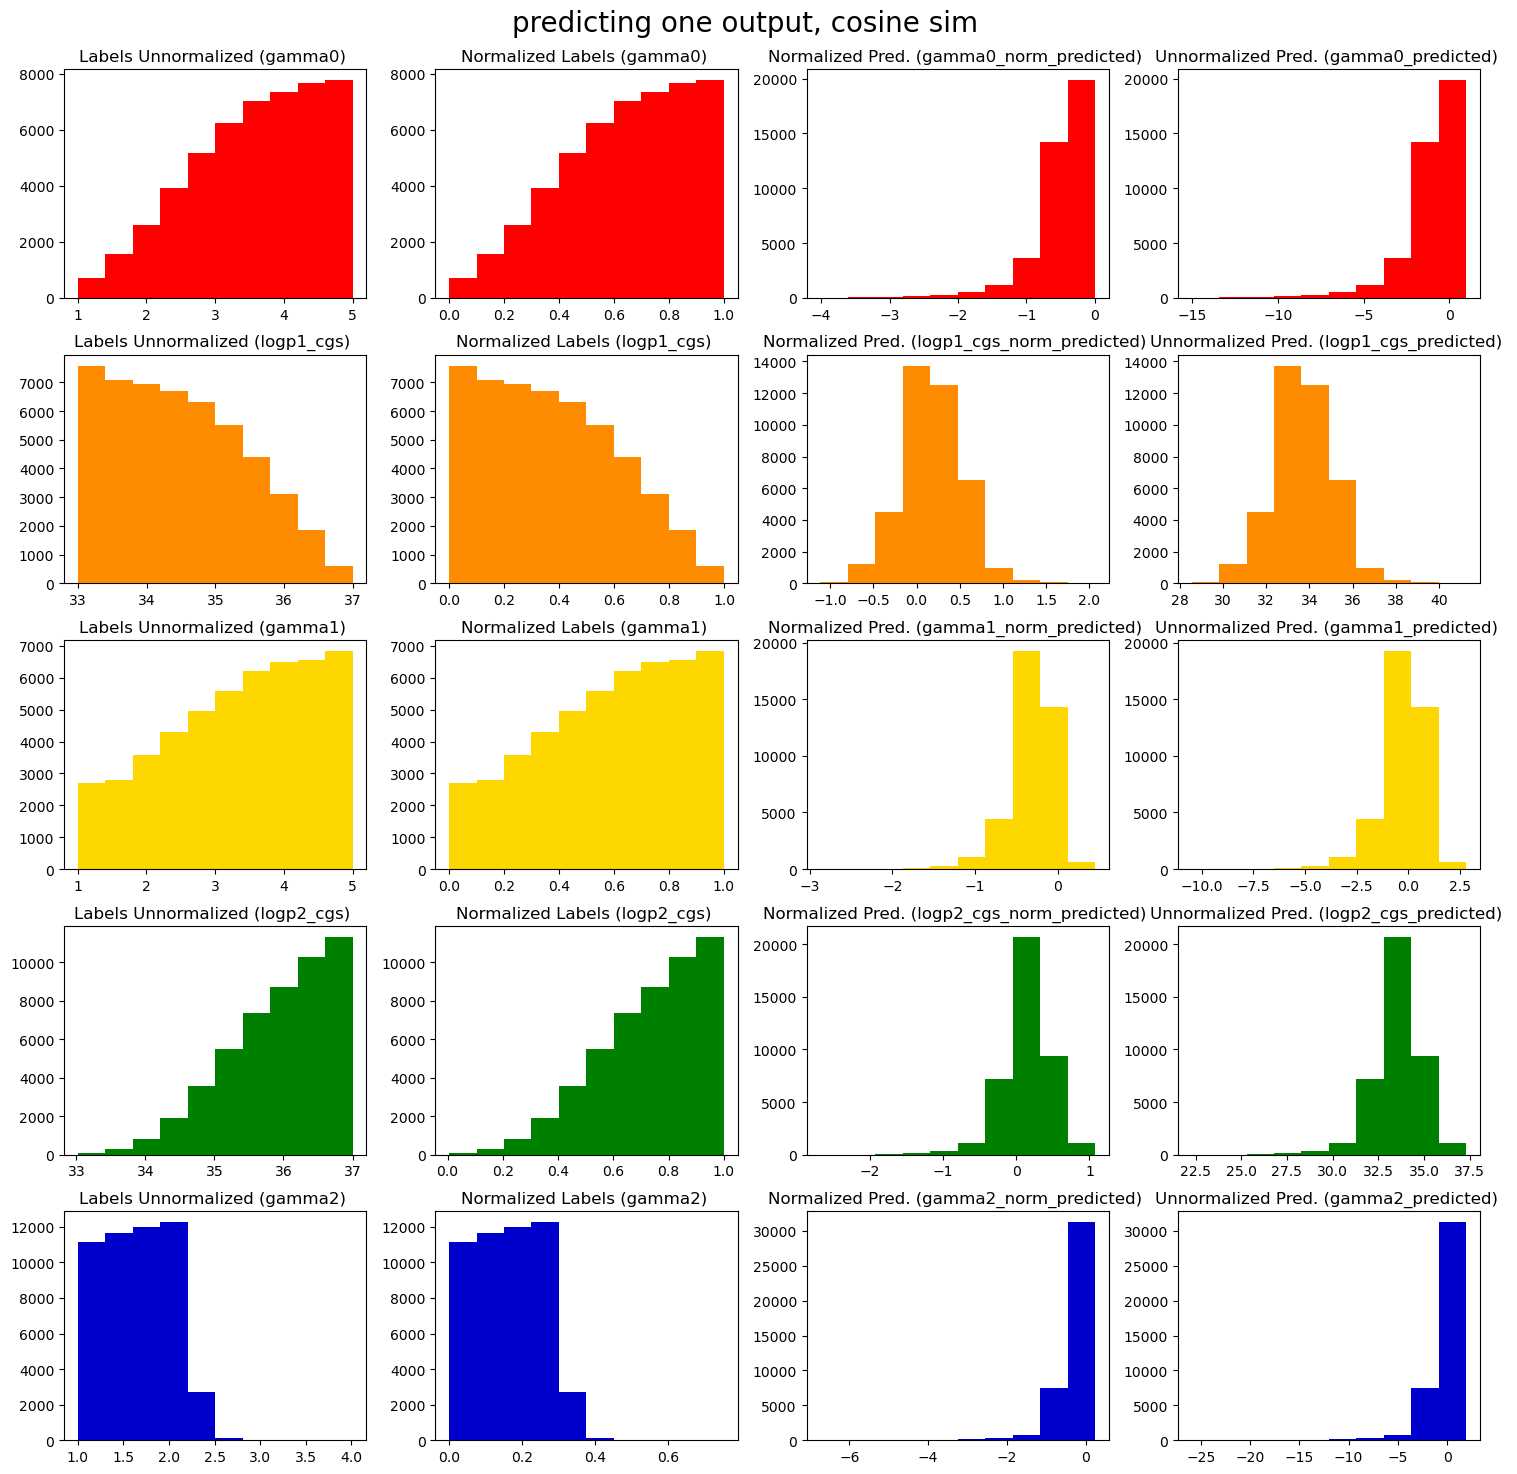

In [335]:
import numpy as np
import matplotlib.pyplot as plt

labels_cols = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']
norm_labels = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']

norm_predictions = ['gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted']
predictions_cols = ['gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted', 'logp2_cgs_predicted', 'gamma2_predicted']


labels = [df[col].to_numpy() for col in labels_cols]
normlabel = [normeddata[col].to_numpy() for col in norm_labels]

normpredictions = [predictions[col].to_numpy() for col in norm_predictions]
prediction = [predictions[col].to_numpy() for col in predictions_cols]


fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i in range(5):
    for j in range(4):
        if j == 0:  #first column i want to be gamma0_labels
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(labels[i], color=color)#, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Labels Unnormalized ({labels_cols[i]}) ")
            
        elif j == 1:  #second column should be the gamm0 predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normlabel[i], color=color) #range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Labels ({norm_labels[i]}) ")
    
          
        elif j == 2:  #3rd column should be the norm labels 
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normpredictions[i], color=color)#, range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Pred. ({norm_predictions[i]}) ")
            
        
        elif j == 3: # 4th column should be the norm predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(prediction[i], color=color)#, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Unnormalized Pred. ({predictions_cols[i]}) ")

plt.tight_layout()
plt.subplots_adjust(top=.94) 
fig.suptitle('predicting one output, cosine sim', fontsize=20)
plt.show()